In [14]:
import sys, os
sys.path.append(os.path.abspath(".."))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from pathlib import Path
import cli_logic as cl
import importlib
import joblib
import pandas as pd
importlib.reload(cl)

BASE_PATH = Path("../cache_new/pitch_results")
results_125 = list(BASE_PATH.rglob("*step125.pkl"))
game_id_list = [file.parts[3].split("_")[0] for file in results_125]
cols = ["frame", "period_id", "gametime_td", "player_x", "player_y", "DAS"]
dfs = []

for (id, file) in zip(game_id_list, results_125):
    game = cl.load_game(id)
    df_tracking_filtered = cl.filter_tracking_data(game, 125)
    df_frameified = cl.frameify_tracking_data(df_tracking_filtered, game)
    
    pr = joblib.load(file)
    df_frameified["DAS"] = pr.das
    df_frames = df_frameified[df_frameified["player_id"] == "ball"][cols]
    df_frames["game_id"] = id
    dfs.append(df_frames)

df_all = pd.concat(dfs, ignore_index=True)
df_all

,frame,period_id,gametime_td,player_x,player_y,DAS,game_id
0,10055,1,00:02,18.69,4.23,0.245419,J03WQQ
1,10463,1,00:18,-9.53,24.82,0.700089,J03WQQ
2,10796,1,00:31,39.59,21.03,7.049552,J03WQQ
3,11194,1,00:47,48.86,30.98,0.000266,J03WQQ
4,12326,1,01:33,41.78,-30.23,7.314296,J03WQQ
...,...,...,...,...,...,...,...
1623,175570,2,90:00+5:22,41.96,5.78,0.009696,J03WPY
1624,175695,2,90:00+5:27,38.00,9.58,0.017417,J03WPY
1625,175980,2,90:00+5:39,-39.53,-1.58,0.041964,J03WPY
1626,176355,2,90:00+5:54,31.21,-27.92,5.446852,J03WPY


In [62]:
# Sekunden vorbereiten

from math import nan
import numpy as np

def parse_gametime_to_seconds(val):
    if pd.isna(val):
        return nan
    s = str(val)
    if "+" in s:
        base, extra = s.split("+", 1)
        return mmss_to_sec(base) + mmss_to_sec(extra)
    else:
        return mmss_to_sec(s)

def mmss_to_sec(mmss):
    m, s = mmss.split(":")
    return int(m)*60 + int(s)

def seconds_within_period(row):
    t = parse_gametime_to_seconds(row["gametime_td"])
    p = row["period_id"]
    if p == 2:
        return t - 45*60
    return t

def linearize_time_per_game(g, break_sec=15*60):
    g = g.copy()
    g["t_in_period_sec"] = g.apply(seconds_within_period, axis=1)
    g = g.sort_values(["period_id", "t_in_period_sec"])
    
    offsets = {}
    acc = 0.0
    for p in sorted(g["period_id"].unique()):
        offsets[p] = acc
        dur = g.loc[g["period_id"] == p, "t_in_period_sec"].max()
        acc += float(dur) + (break_sec if p != g["period_id"].max() else 0)

    g["t_linear_sec"] = g["t_in_period_sec"] + g["period_id"].map(offsets)
    g["t_linear_min"] = g["t_linear_sec"] / 60.0
    return g

df = df_all.copy()

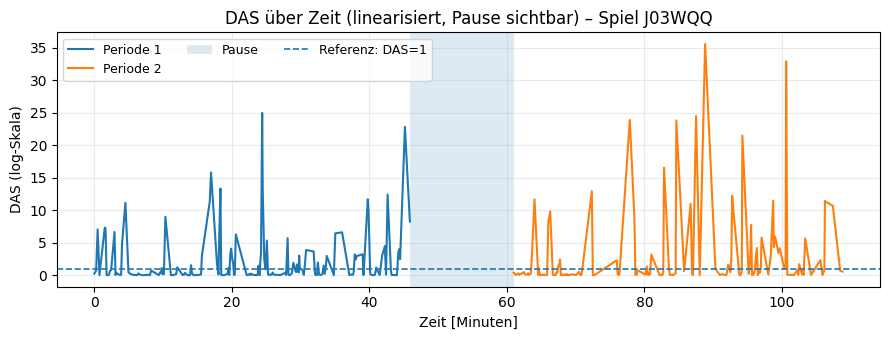

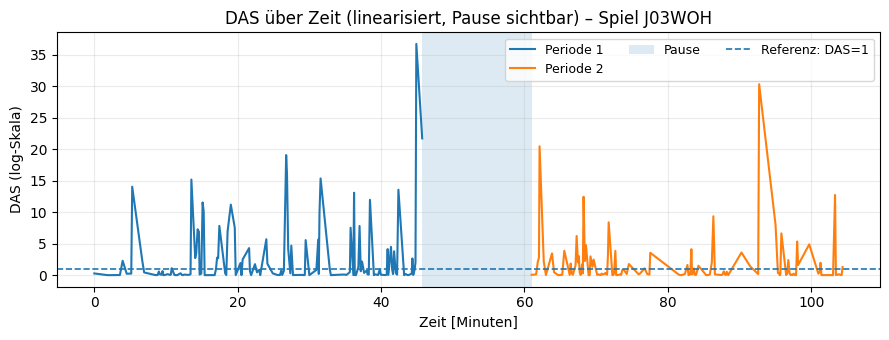

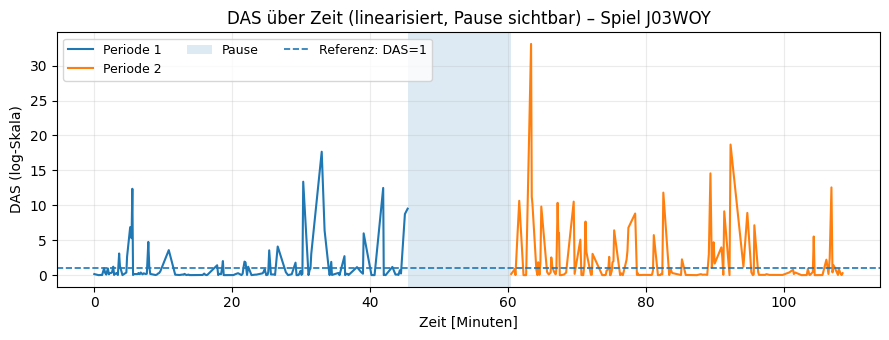

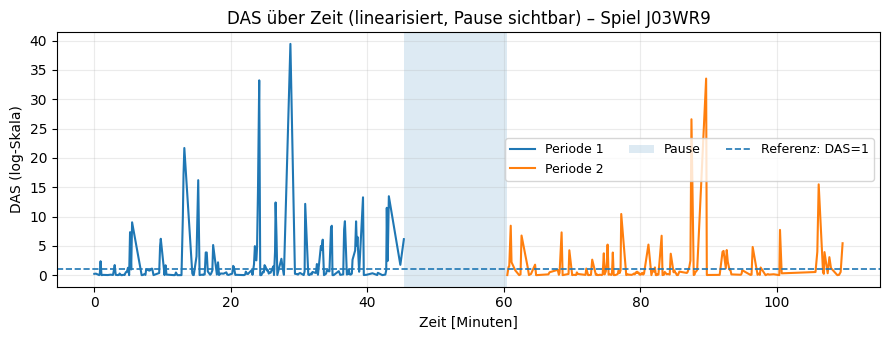

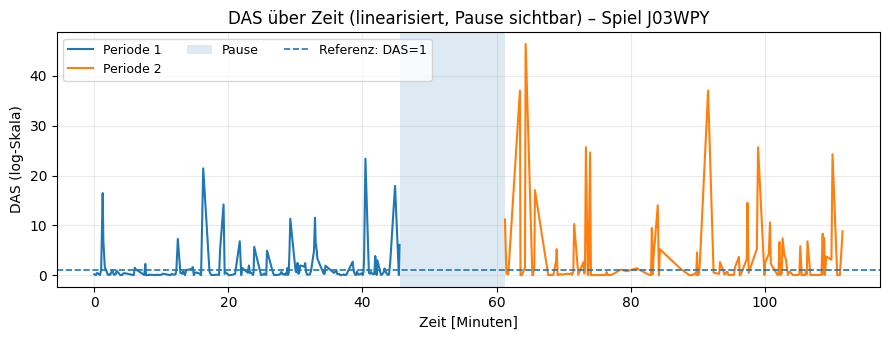

In [ ]:
# Zeitverlauf DAS
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_das_timeseries_with_pause(
    df: pd.DataFrame,
    break_min: int = 15,
    ref_das: float = 1.0,
    linewidth: float = 1.5,
):
    dfs = [linearize_time_per_game(g, break_sec=break_min*60)
           for _, g in df.groupby("game_id", sort=False)]
    df_lin = pd.concat(dfs, ignore_index=True)
    
    for gid, sub in df_lin.groupby("game_id", sort=False):
        fig, ax = plt.subplots(figsize=(9, 3.5))
        for p, seg in sub.groupby("period_id", sort=False):
            seg = seg.sort_values("t_linear_sec")
            ax.plot(seg["t_linear_min"], seg["DAS"], linewidth=linewidth, label=f"Periode {p}")
        periods = sorted(sub["period_id"].unique())
        for p_this, p_next in zip(periods, periods[1:]):
            end_this = sub.loc[sub["period_id"] == p_this, "t_linear_min"].max()
            start_next = sub.loc[sub["period_id"] == p_next, "t_linear_min"].min()
            ax.axvspan(end_this, start_next, alpha=0.15, label="Pause" if p_this == periods[0] else None)
        if ref_das is not None and ref_das > 0:
            ax.axhline(ref_das, linestyle="--", linewidth=1.2, label=f"Referenz: DAS={ref_das:g}")
            
        # ax.set_yscale("symlog", linthresh=0.5, linscale=1)
        # ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y:g}"))
        ax.set_title(f"DAS über Zeit (linearisiert, Pause sichtbar) – Spiel {gid}")
        ax.set_xlabel("Zeit [Minuten]")
        ax.set_ylabel("DAS (log-Skala)")
        ax.grid(True, which="both", axis="both", alpha=0.25)
        ax.legend(ncol=3, fontsize=9)
        plt.tight_layout()
        plt.show()

plot_das_timeseries_with_pause(df)


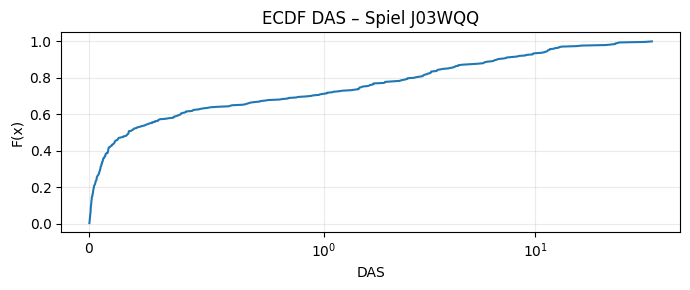

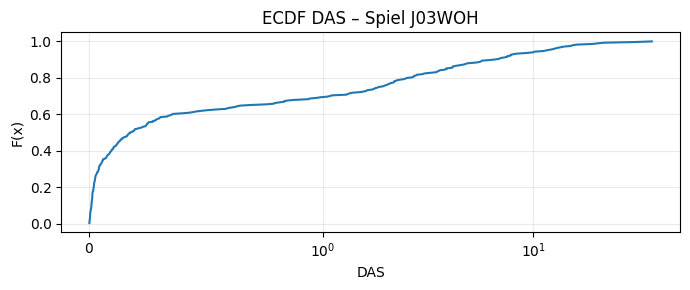

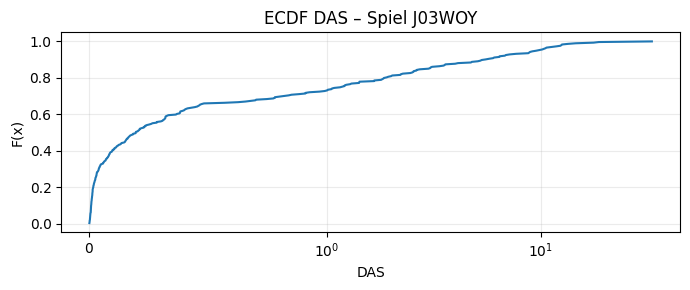

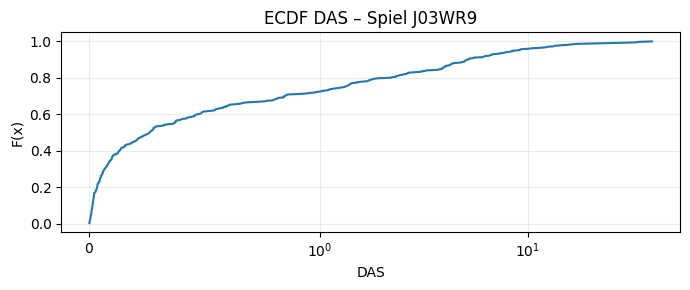

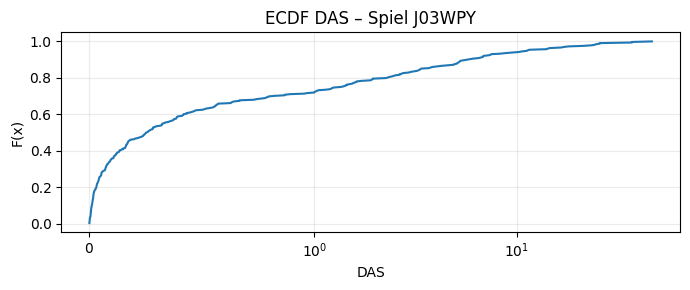

In [77]:
# Verteilung DAS pro Spieler
def histogram_verteilung(df):
    for gid, sub in df.groupby("game_id", sort=False):
        x = sub["DAS"].dropna().values
        if len(x) == 0: 
            continue

        fig, ax = plt.subplots(figsize=(6, 3))
        ax.hist(x, bins="fd", density=True, alpha=0.5)
        # KDE (pandas intern)
        #pd.Series(x).plot(kind="kde", ax=ax)
        ax.set_title(f"Verteilung DAS – Spiel {gid}")
        ax.set_xlabel("DAS")
        ax.set_ylabel("Dichte")
        plt.show()

def plot_hist_per_game(df, thr=1.0):
    for gid, sub in df.groupby("game_id", sort=False):
        x = sub["DAS"].dropna().values
        if len(x) == 0: 
            continue
        bins = mixed_bins(x.max(), thr=thr, fine=0.025, tail_bins=12)

        fig, ax = plt.subplots(figsize=(7,3))
        ax.hist(x, bins=bins, density=True, alpha=0.6)

        ax.set_xscale("symlog", linthresh=thr, linscale=1)
        ax.xaxis.set_major_formatter(FuncFormatter(lambda v,_: f"{v:g}"))

        ax.set_title(f"Verteilung DAS – Spiel {gid}")
        ax.set_xlabel("DAS (linear ≤1, log >1)")
        ax.set_ylabel("Dichte")
        ax.grid(True, which="both", alpha=0.25)
        plt.tight_layout()
        plt.show()     
         
def mixed_bins(maxx, thr=1.0, fine=0.025, tail_bins=12):
    left = np.arange(0, min(thr, maxx) + 1e-12, fine)
    if maxx <= thr + 1e-9:
        return left
    tail_start = max(thr + 1e-6, 1.01)  # Start leicht über 1
    right = np.geomspace(tail_start, maxx * 1.001, tail_bins)
    edges = np.unique(np.concatenate([left, right]))
    return edges


def plot_ecdf_per_game(df, tail_focus=False):
    for gid, sub in df.groupby("game_id", sort=False):
        x = sub["DAS"].dropna().values
        if len(x) == 0: 
            continue
        xx, yy = ecdf(x)

        fig, ax = plt.subplots(figsize=(7,3))
        if tail_focus:
            # CCDF = 1 - ECDF, log-Y betont die Tails
            ax.plot(xx, 1-yy)
            ax.set_yscale("log")
            ax.set_ylabel("1 - F(x) (log)")
            ax.set_title(f"CCDF DAS – Spiel {gid} (Tail-Betont)")
        else:
            ax.plot(xx, yy)
            ax.set_ylabel("F(x)")
            ax.set_title(f"ECDF DAS – Spiel {gid}")

        # x optional symlog, um >1 zu komprimieren
        ax.set_xscale("symlog", linthresh=1, linscale=1)
        ax.grid(True, which="both", alpha=0.25)
        ax.set_xlabel("DAS")
        plt.tight_layout()
        plt.show()

def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y
# histogram_verteilung(df)
# plot_hist_per_game(df)
plot_ecdf_per_game(df)